In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



**Fitting Bézier Curves to Contours from an Image**


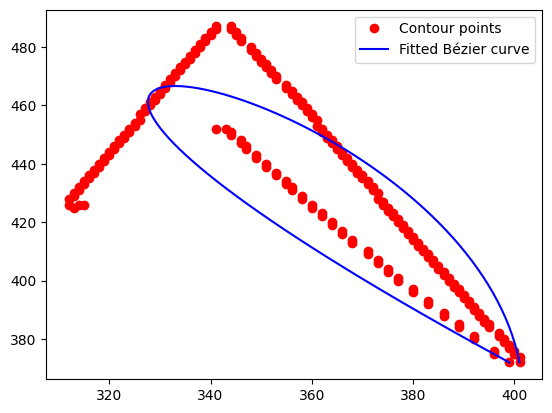

In [ ]:
import cv2
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Preprocessing the image
def preprocess_image(image_path):
    #Load image, convert to grayscale, threshold, and detect edges.
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, thresholded = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
    edges = cv2.Canny(thresholded, 50, 150)
    return edges

# Extracting the contours
def extract_contours(edges):
    #Find and return the largest contour in the edge-detected image.
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)  # Get the largest contour
    contour = contour.reshape(-1, 2)  # Reshape for easier handling
    return contour

# Bézier curve function
def bezier_curve(t, p0, p1, p2, p3):
    #Compute Bézier curve points.
    return (1 - t)**3 * p0 + 3 * (1 - t)**2 * t * p1 + 3 * (1 - t) * t**2 * p2 + t**3 * p3

# Fitting the Bézier curve
def fit_bezier(contour):
    #Fit a Bézier curve to the contour points.
    t = np.linspace(0, 1, len(contour))  # Parameter t
    x, y = contour[:, 0], contour[:, 1]  # Contour coordinates

    # Initial guess for the control points
    p0 = contour[0]
    p3 = contour[-1]
    p1 = (2/3 * p0 + 1/3 * p3)
    p2 = (1/3 * p0 + 2/3 * p3)

    popt_x, _ = curve_fit(lambda t, p1, p2: bezier_curve(t, p0[0], p1, p2, p3[0]), t, x, p0=[p1[0], p2[0]])
    popt_y, _ = curve_fit(lambda t, p1, p2: bezier_curve(t, p0[1], p1, p2, p3[1]), t, y, p0=[p1[1], p2[1]])

    return p0, [popt_x[0], popt_y[0]], [popt_x[1], popt_y[1]], p3

# Plotting the results
def plot_results(contour, bezier_points):
    #Plot contour points and fitted Bézier curve.
    t = np.linspace(0, 1, 100)
    bezier_x = bezier_curve(t, bezier_points[0][0], bezier_points[1][0], bezier_points[2][0], bezier_points[3][0])
    bezier_y = bezier_curve(t, bezier_points[0][1], bezier_points[1][1], bezier_points[2][1], bezier_points[3][1])

    plt.plot(contour[:, 0], contour[:, 1], 'ro', label='Contour points')
    plt.plot(bezier_x, bezier_y, 'b-', label='Fitted Bézier curve')
    plt.legend()
    plt.show()

# Main function
def main(image_path):
    #Main function to preprocess image, extract contours, fit Bézier curve, and plot results.
    edges = preprocess_image(image_path)
    contour = extract_contours(edges)
    bezier_points = fit_bezier(contour)
    plot_results(contour, bezier_points)

# Run the main function
image_path = '/content/drive/MyDrive/art.png'
main(image_path)


**Shape Detection and Classification in Images Using Contours and Polygon Approximation**

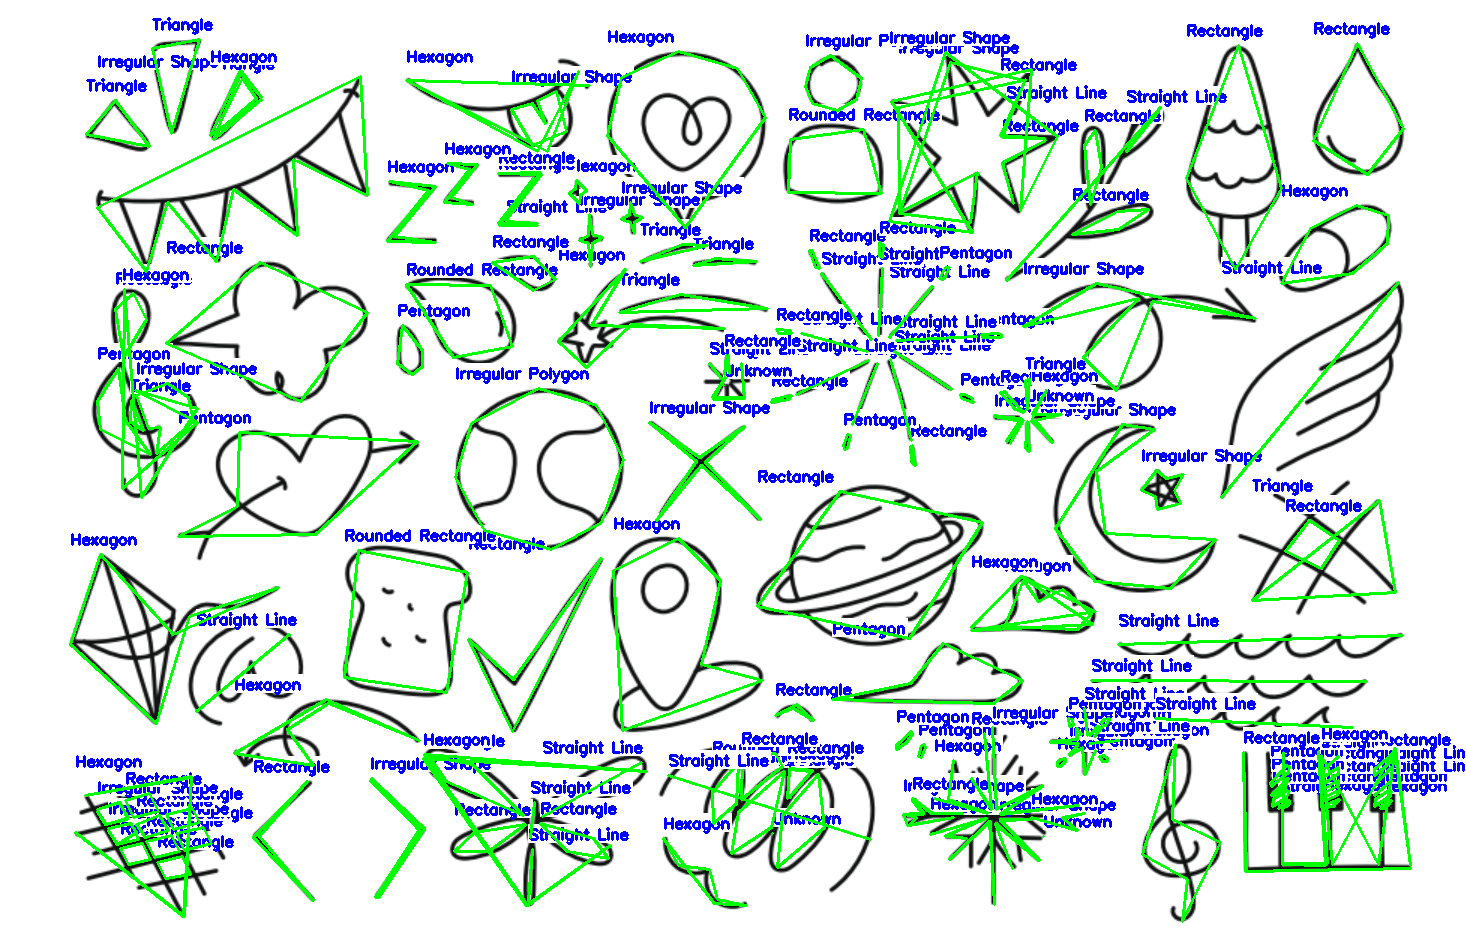

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def detect_shapes(image_path, zoom_factor=1.0):

    # Read the image from the file
    image = cv2.imread(image_path)

    # Resize the image based on the zoom factor
    if zoom_factor != 1.0:
        image = cv2.resize(image, None, fx=zoom_factor, fy=zoom_factor, interpolation=cv2.INTER_LINEAR)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Perform edge detection using Canny algorithm
    edged = cv2.Canny(blurred, 50, 150)

    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Process each contour found
    for contour in contours:
        # Approximate the contour to a polygon
        peri = cv2.arcLength(contour, True)  # Calculate perimeter
        approx = cv2.approxPolyDP(contour, 0.04 * peri, True)  # Approximate contour shape

        # Get the bounding box of the approximated contour
        x, y, w, h = cv2.boundingRect(approx)  # Calculate bounding box

        # Default shape to "Unknown"
        shape = "Unknown"

        # Determine the shape based on the number of vertices
        if len(approx) == 2:
            shape = "Straight Line"
        elif len(approx) == 3:
            shape = "Triangle"  # 3 vertices
        elif len(approx) == 4:
            aspect_ratio = w / float(h)
            shape = "Square" if 0.95 <= aspect_ratio <= 1.05 else "Rectangle"
            if shape == "Rectangle":
                if cv2.contourArea(contour) / (w * h) > 0.75:  # Threshold can be adjusted
                    shape = "Rounded Rectangle"
        elif len(approx) == 5:
            shape = "Pentagon"  # 5 vertices
        elif len(approx) == 6:
            shape = "Hexagon"  # 6 vertices
        elif len(approx) > 6:
            # Check for regular polygons
            if cv2.isContourConvex(approx):
                distances = []
                angles = []
                num_points = len(approx)

                # Calculate distances between adjacent vertices
                for i in range(num_points):
                    p1 = approx[i][0]
                    p2 = approx[(i + 1) % num_points][0]
                    dist = np.linalg.norm(p1 - p2)
                    distances.append(dist)

                # Calculate angles between adjacent sides
                for i in range(num_points):
                    p1 = approx[i][0]
                    p2 = approx[(i + 1) % num_points][0]
                    p3 = approx[(i + 2) % num_points][0]
                    angle = np.arccos(np.dot(p2 - p1, p3 - p2) / (np.linalg.norm(p2 - p1) * np.linalg.norm(p3 - p2)))
                    angles.append(np.degrees(angle))

                # Heuristic for regular polygons
                if (max(distances) - min(distances) < 0.1 * np.mean(distances) and
                    max(angles) - min(angles) < 10):  # Adjust tolerance as needed
                    shape = "Regular Polygon"
                else:
                    shape = "Irregular Polygon"

            else:
                shape = "Irregular Shape"
        else:
            if len(contour) >= 5:  # Check if there are enough points to fit an ellipse
                (x, y), (MA, ma), angle = cv2.fitEllipse(contour)
                shape = "Circle" if abs(MA - ma) < 10 else "Ellipse"

            # Detect star shape
            # Fit convex hull
            hull = cv2.convexHull(contour)
            if len(hull) >= 10:  # Heuristic: More than 10 points could indicate a star
                center = np.mean(hull, axis=0)
                distances = [np.linalg.norm(point - center) for point in hull]
                std_dev = np.std(distances)
                if std_dev < 0.1 * np.mean(distances):  # Heuristic for radial symmetry
                    shape = "Star"

        # Draw the contour
        cv2.drawContours(image, [approx], -1, (0, 255, 0), 2)  # Draw contour in green

        # Determine text position to avoid overlap
        text_x, text_y = int(x), int(y - 10)
        if text_y < 20:
            text_y = int(y + h + 20)  # Move text below the shape if it’s too close to the top edge

        # Draw a semi-transparent background box behind the text
        text = shape
        font_scale = 0.5
        thickness = 2
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)[0]
        text_bg_top_left = (text_x, text_y - text_size[1] - 3)
        text_bg_bottom_right = (text_x + text_size[0], text_y + 3)
        cv2.rectangle(image, text_bg_top_left, text_bg_bottom_right, (255, 255, 255), -1)

        # Label the detected shape
        cv2.putText(image, shape, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 0, 0), thickness)

    # Display the output image
    cv2_imshow(image)  # Use cv2_imshow for Google Colab
    cv2.waitKey(0)  # Wait for a key press
    cv2.destroyAllWindows()  # Close all OpenCV windows

# Main function to run shape detection
if __name__ == "__main__":
    image_path = "/content/drive/MyDrive/art.png"  # Path to the input image
    detect_shapes(image_path, zoom_factor=1.5)  # Call the function to detect shapes with zoom


Straight Line: 28
Circle: 0
Ellipse: 0
Triangle: 10
Square: 0
Rectangle: 44
Rounded Rectangle: 4
Pentagon: 17
Hexagon: 31
Regular Polygon: 0
Star: 5
Unknown: 5
Irregular Shape: 17


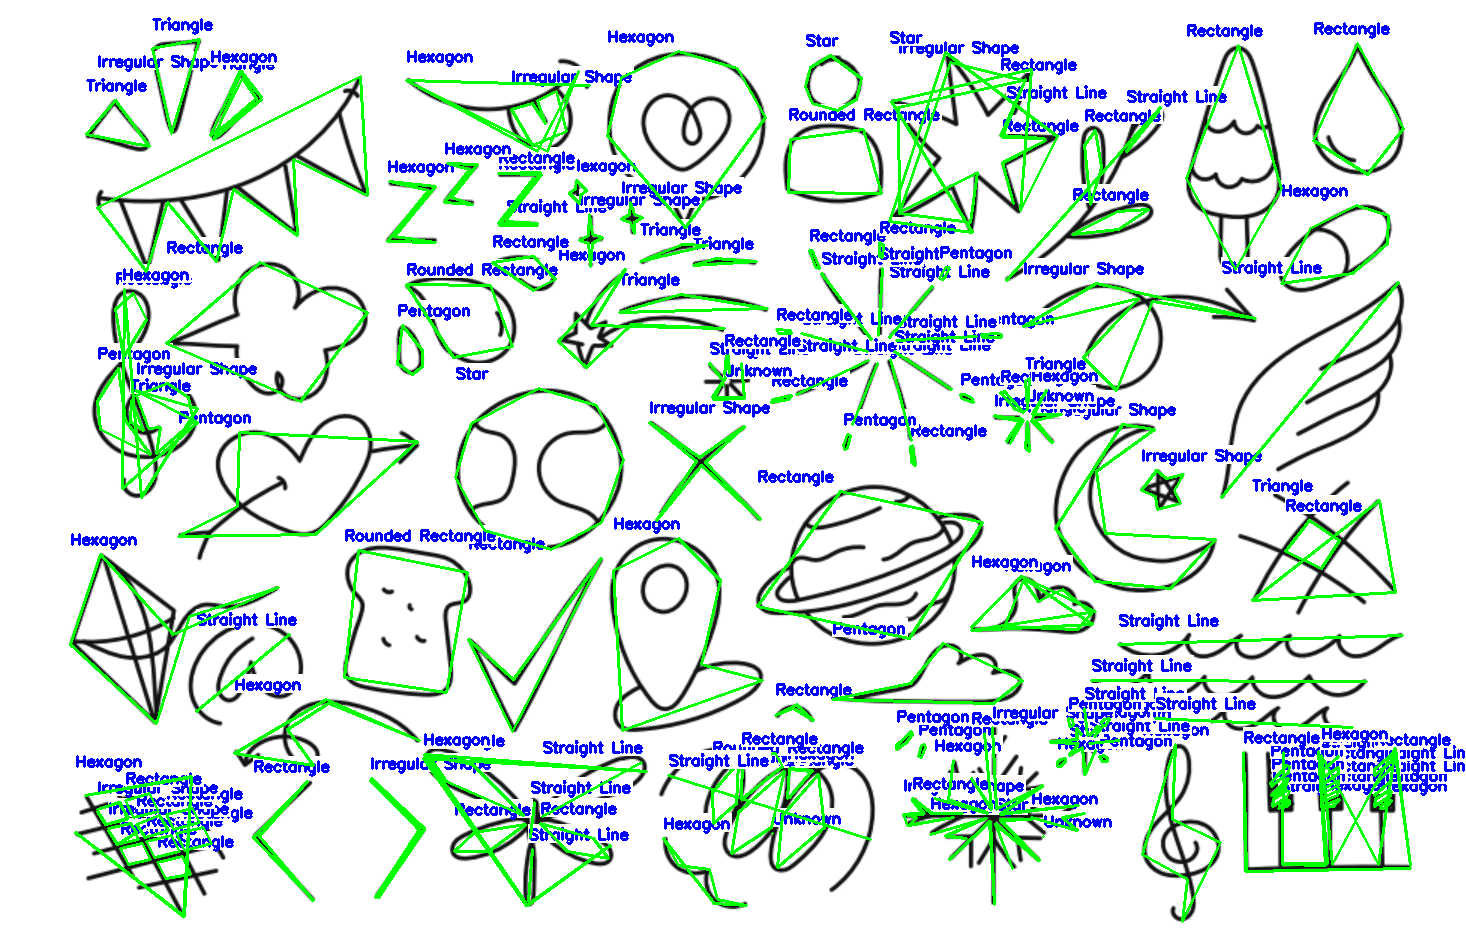

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def detect_shapes(image_path, zoom_factor=1.0):
    # Read the image from the file
    image = cv2.imread(image_path)

    # Resize the image based on the zoom factor
    if zoom_factor != 1.0:
        image = cv2.resize(image, None, fx=zoom_factor, fy=zoom_factor, interpolation=cv2.INTER_LINEAR)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Perform edge detection using Canny algorithm
    edged = cv2.Canny(blurred, 50, 150)

    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Dictionary to keep track of the number of each shape
    shape_counts = {
        "Straight Line": 0,
        "Circle": 0,
        "Ellipse": 0,
        "Triangle": 0,
        "Square": 0,
        "Rectangle": 0,
        "Rounded Rectangle": 0,
        "Pentagon": 0,
        "Hexagon": 0,
        "Regular Polygon": 0,
        "Star": 0
    }

    # Process each contour found
    for contour in contours:
        # Approximate the contour to a polygon
        peri = cv2.arcLength(contour, True)  # Calculate perimeter
        approx = cv2.approxPolyDP(contour, 0.04 * peri, True)  # Approximate contour shape

        # Get the bounding box of the approximated contour
        x, y, w, h = cv2.boundingRect(approx)  # Calculate bounding box

        # Default shape to "Unknown"
        shape = "Unknown"

        # Determine the shape based on the number of vertices
        if len(approx) == 2:
            shape = "Straight Line"
        elif len(approx) == 3:
            shape = "Triangle"  # 3 vertices
        elif len(approx) == 4:
            aspect_ratio = w / float(h)
            shape = "Square" if 0.95 <= aspect_ratio <= 1.05 else "Rectangle"
            if shape == "Rectangle":
                if cv2.contourArea(contour) / (w * h) > 0.75:  # Threshold can be adjusted
                    shape = "Rounded Rectangle"
        elif len(approx) == 5:
            shape = "Pentagon"  # 5 vertices
        elif len(approx) == 6:
            shape = "Hexagon"  # 6 vertices
        elif len(approx) > 6:
            if cv2.isContourConvex(approx):
                distances = []
                angles = []
                num_points = len(approx)

                # Calculate distances between adjacent vertices
                for i in range(num_points):
                    p1 = approx[i][0]
                    p2 = approx[(i + 1) % num_points][0]
                    dist = np.linalg.norm(p1 - p2)
                    distances.append(dist)

                # Calculate angles between adjacent sides
                for i in range(num_points):
                    p1 = approx[i][0]
                    p2 = approx[(i + 1) % num_points][0]
                    p3 = approx[(i + 2) % num_points][0]
                    angle = np.arccos(np.dot(p2 - p1, p3 - p2) / (np.linalg.norm(p2 - p1) * np.linalg.norm(p3 - p2)))
                    angles.append(np.degrees(angle))

                # Heuristic for regular polygons
                if (max(distances) - min(distances) < 0.1 * np.mean(distances) and
                    max(angles) - min(angles) < 10):  # Adjust tolerance as needed
                    shape = "Regular Polygon"
                else:
                    shape = "Irregular Polygon"

            else:
                shape = "Irregular Shape"

            # Detect star shape
            # Fit convex hull
            hull = cv2.convexHull(contour)
            if len(hull) >= 10:  # Heuristic: More than 10 points could indicate a star
                center = np.mean(hull, axis=0)
                distances = [np.linalg.norm(point - center) for point in hull]
                std_dev = np.std(distances)
                if std_dev < 0.1 * np.mean(distances):  # Heuristic for radial symmetry
                    shape = "Star"

        # Update the count for the detected shape
        if shape in shape_counts:
            shape_counts[shape] += 1
        else:
            shape_counts[shape] = 1

        # Draw the contour
        cv2.drawContours(image, [approx], -1, (0, 255, 0), 2)  # Draw contour in green

        # Determine text position to avoid overlap
        text_x, text_y = int(x), int(y - 10)
        if text_y < 20:
            text_y = int(y + h + 20)  # Move text below the shape if it’s too close to the top edge

        # Draw a semi-transparent background box behind the text
        text = shape
        font_scale = 0.5
        thickness = 2
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)[0]
        text_bg_top_left = (text_x, text_y - text_size[1] - 3)
        text_bg_bottom_right = (text_x + text_size[0], text_y + 3)
        cv2.rectangle(image, text_bg_top_left, text_bg_bottom_right, (255, 255, 255), -1)

        # Label the detected shape
        cv2.putText(image, shape, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 0, 0), thickness)

    # Print the counts of each shape
    for shape, count in shape_counts.items():
        print(f"{shape}: {count}")

    # Display the output image
    cv2_imshow(image)  # Use cv2_imshow for Google Colab
    cv2.waitKey(0)  # Wait for a key press
    cv2.destroyAllWindows()  # Close all OpenCV windows

# Main function to run shape detection
if __name__ == "__main__":
    image_path = "/content/drive/MyDrive/art.png"  # Path to the input image
    detect_shapes(image_path, zoom_factor=1.5)  # Call the function to detect and count shapes with zoom


**1.Straight lines.**

Number of straight lines detected: 14


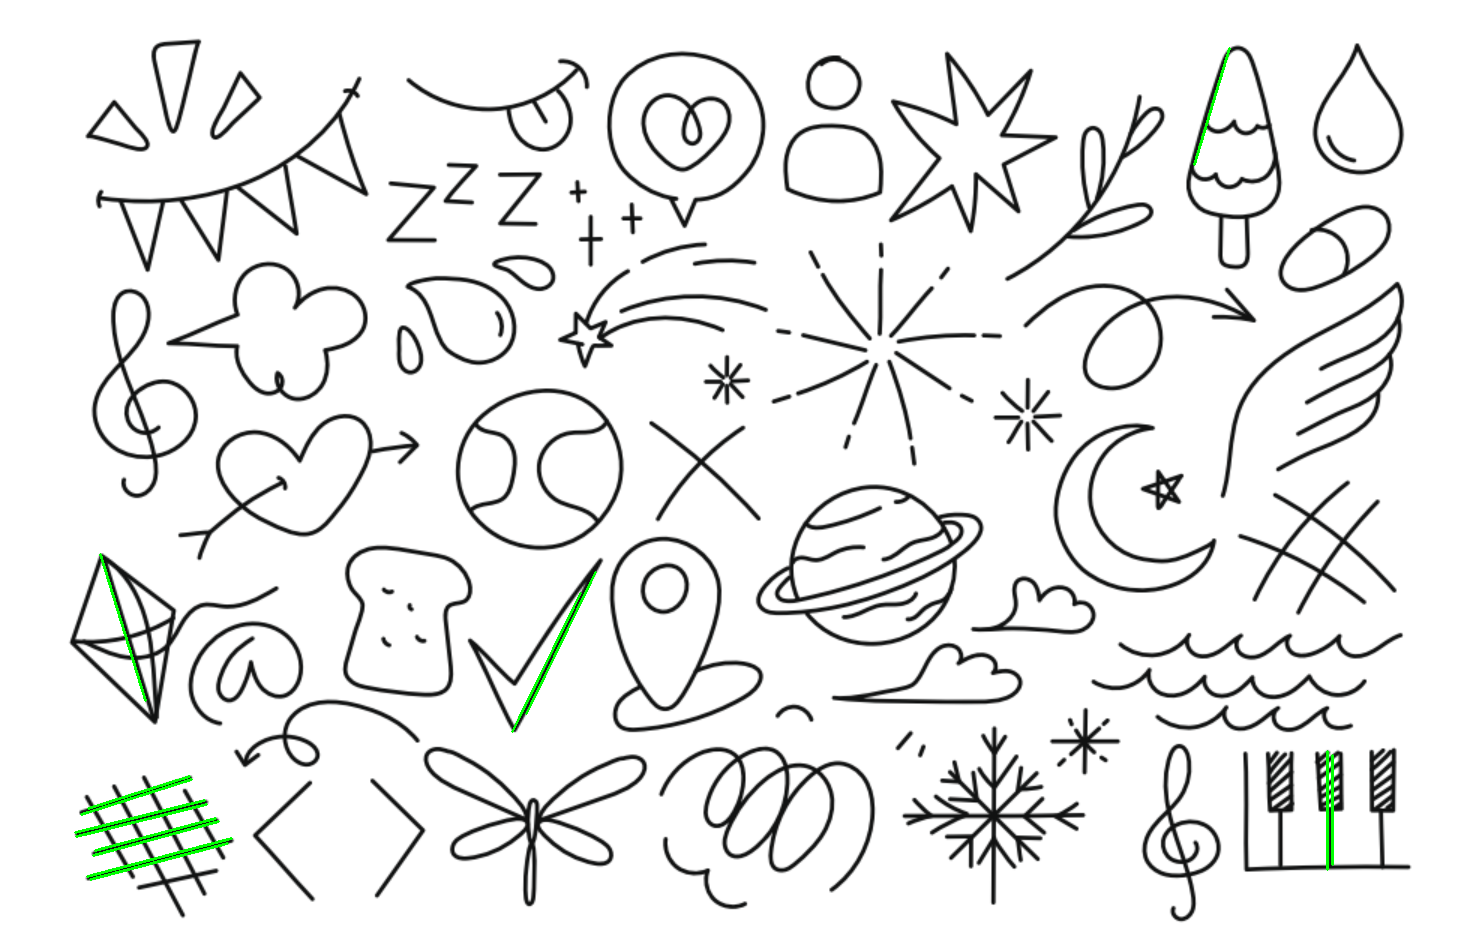

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def detect_and_count_straight_lines(image_path, zoom_factor=1.0):
    # Read and resize the image
    image = cv2.imread(image_path)
    if zoom_factor != 1.0:
        image = cv2.resize(image, None, fx=zoom_factor, fy=zoom_factor, interpolation=cv2.INTER_LINEAR)

    # Convert to grayscale and apply Gaussian blur
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 50, 150)

    # Detect straight lines using Hough Line Transform
    lines = cv2.HoughLinesP(edged, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)
    line_count = 0

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            line_count += 1

    print(f"Number of straight lines detected: {line_count}")
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Main function
if __name__ == "__main__":
    image_path = "/content/drive/MyDrive/art.png"
    detect_and_count_straight_lines(image_path, zoom_factor=1.5)



**Circles**

Number of circles detected: 8


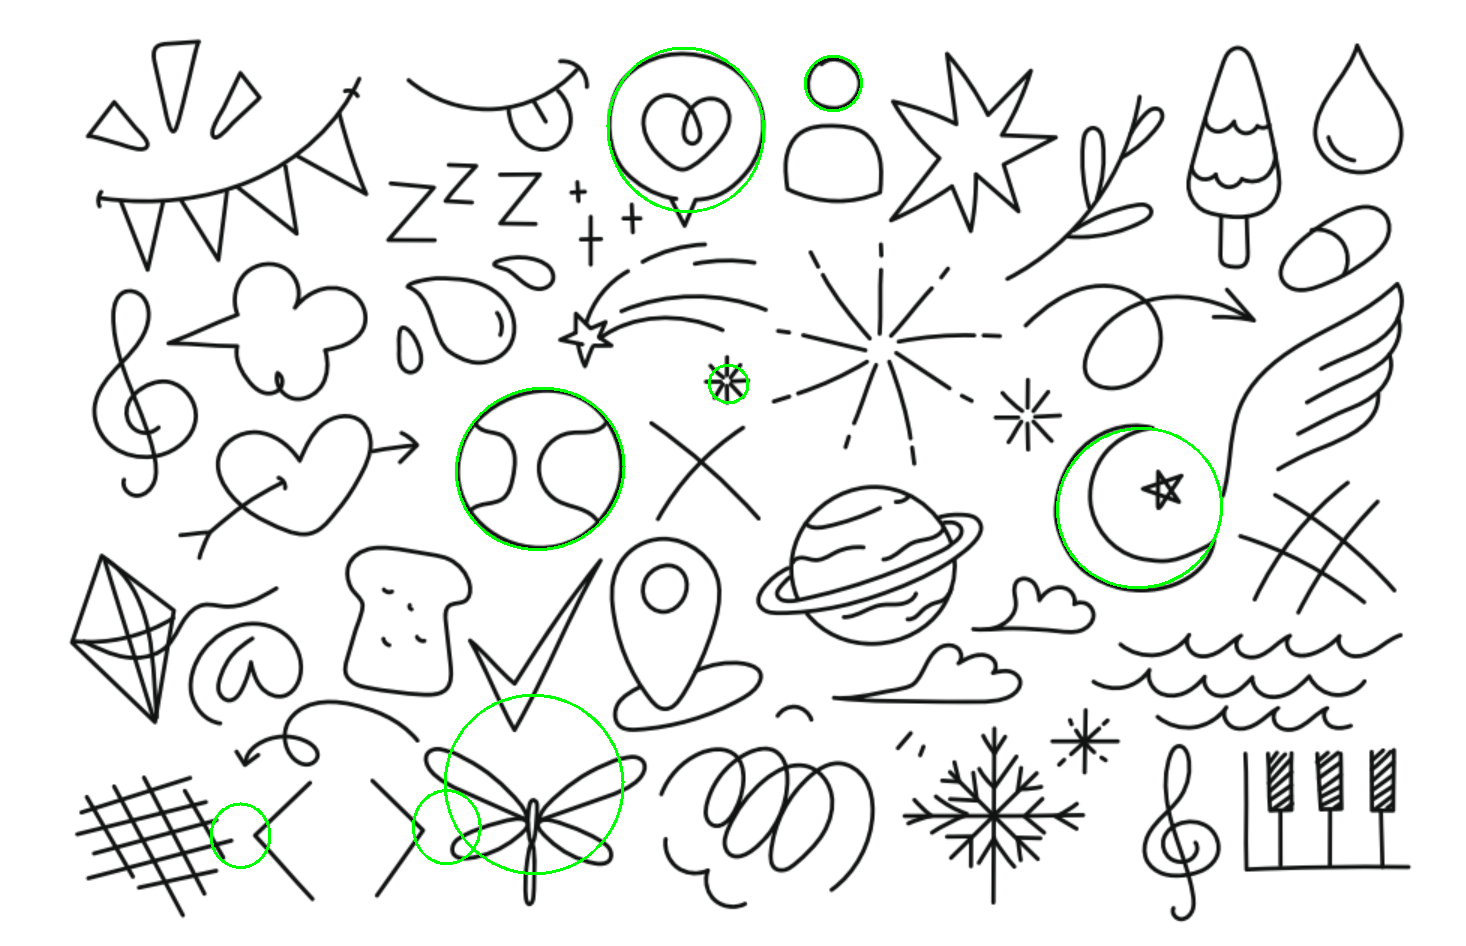

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def detect_circles_by_radial_symmetry(image_path, zoom_factor=1.0):
    # Read and resize the image
    image = cv2.imread(image_path)
    if zoom_factor != 1.0:
        image = cv2.resize(image, None, fx=zoom_factor, fy=zoom_factor, interpolation=cv2.INTER_LINEAR)

    # Convert to grayscale and apply Gaussian blur
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    circle_count = 0

    for contour in contours:
        # Fit an ellipse to the contour
        if len(contour) >= 5:
            ellipse = cv2.fitEllipse(contour)
            (x, y), (MA, ma), angle = ellipse

            # Check if the ellipse is a circle (radii MA and ma should be close)
            if abs(MA - ma) < 0.1 * max(MA, ma):  # Tolerance for circle detection
                cv2.ellipse(image, ellipse, (0, 255, 0), 2)
                circle_count += 1

    print(f"Number of circles detected: {circle_count}")
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Main function
if __name__ == "__main__":
    image_path = "/content/drive/MyDrive/art.png"
    detect_circles_by_radial_symmetry(image_path, zoom_factor=1.5)


**Symmetric Curves**

Number of symmetric curves detected: 47


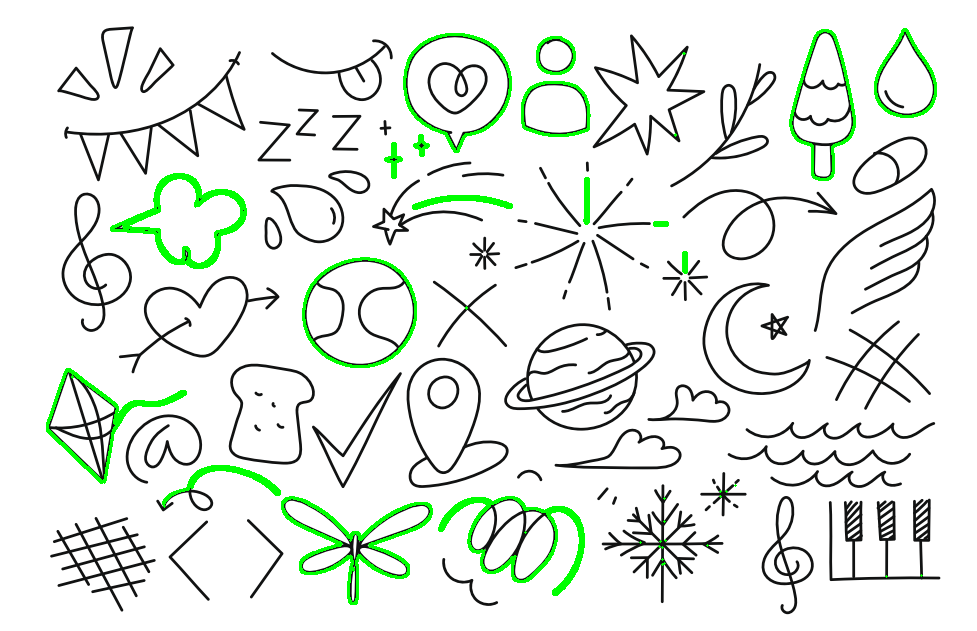

In [ ]:
import cv2
import numpy as np

# Function to identify and count symmetric curves
def detect_symmetric_curves(image_path):
    # Read the image from the file
    image = cv2.imread(image_path)  # Load the image from the specified path

    # Convert the image to grayscale for easier processing
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert the image to grayscale

    # Apply Gaussian blur to the grayscale image to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # Blur the image to smooth out noise

    # Perform edge detection to find edges in the image
    edged = cv2.Canny(blurred, 50, 150)  # Detect edges using the Canny algorithm

    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # cv2.findContours finds contours in a binary image
    # - cv2.RETR_EXTERNAL: Retrieve only external contours
    # - cv2.CHAIN_APPROX_SIMPLE: Compresses horizontal, vertical, and diagonal segments

    # Initialize symmetric curve count
    symmetric_curve_count = 0

    # Loop over each contour
    for contour in contours:
        # Create a mask from the contour
        mask = np.zeros_like(gray)  # Create an empty mask with the same dimensions as the grayscale image
        cv2.drawContours(mask, [contour], -1, 255, -1)  # Draw the contour on the mask in white

        # Get the bounding box for the contour and extract the Region of Interest (ROI)
        x, y, w, h = cv2.boundingRect(contour)  # Compute the bounding box for the contour
        roi = mask[y:y+h, x:x+w]  # Extract the ROI from the mask

        # Flip the ROI horizontally and vertically
        roi_flipped_horizontally = cv2.flip(roi, 1)  # Flip the ROI horizontally
        roi_flipped_vertically = cv2.flip(roi, 0)    # Flip the ROI vertically

        # Compare the original ROI with its flipped versions
        horizontal_symmetry = np.sum(roi == roi_flipped_horizontally) / roi.size
        vertical_symmetry = np.sum(roi == roi_flipped_vertically) / roi.size
        # Calculate the similarity ratio between the original ROI and its flipped versions

        # Consider a contour symmetric if it is sufficiently similar to its flipped version
        if horizontal_symmetry > 0.9 or vertical_symmetry > 0.9:
            symmetric_curve_count += 1  # Increment the count of symmetric curves
            cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)  # Draw the contour in green on the image

    # Print the number of symmetric curves detected
    print(f"Number of symmetric curves detected: {symmetric_curve_count}")

    # Display the output image with symmetric curves highlighted
    cv2_imshow(image)  # Display the image with contours (use cv2_imshow for Google Colab)
    cv2.waitKey(0)  # Wait indefinitely for a key press
    cv2.destroyAllWindows()  # Close all OpenCV windows

# Main function to execute the symmetric curve detection
if __name__ == "__main__":
    image_path = "/content/drive/MyDrive/art.png"  # Path to the input image (change as needed)
    detect_symmetric_curves(image_path)  # Call the function to detect and count symmetric curves in the image


**Completing Incomplete Curves**

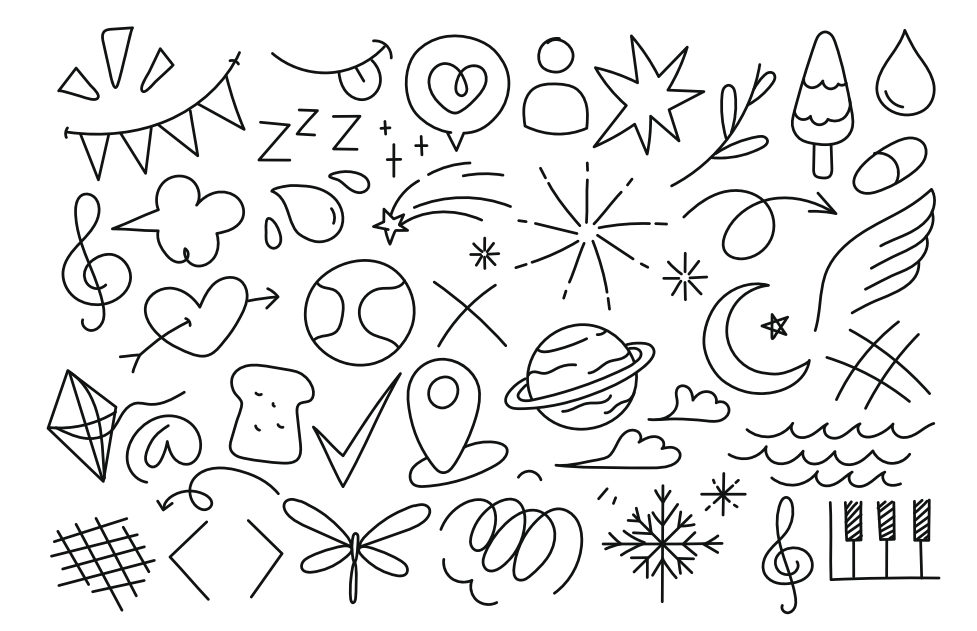

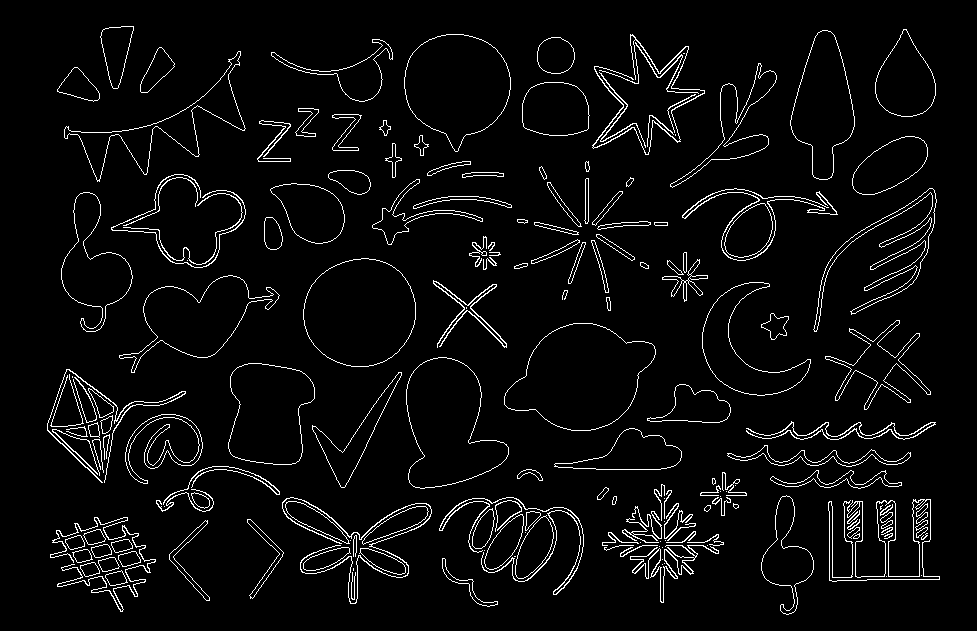

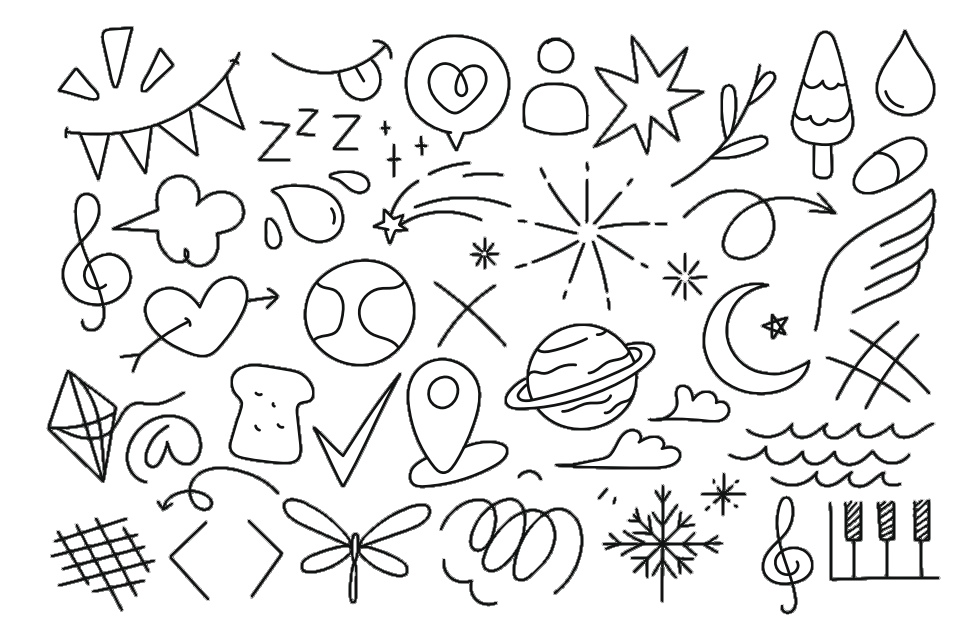

In [ ]:
import cv2
import numpy as np

# Function to complete incomplete curves
def complete_curves(image_path):
    """
    Complete incomplete curves in an image using inpainting.

    Parameters:
    - image_path (str): Path to the input image file.
    """
    # Read the image from the file
    image = cv2.imread(image_path)  # Load the image from the specified path

    # Convert the image to grayscale for easier processing
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert the image to grayscale

    # Apply Gaussian blur to the grayscale image to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # Blur the image to smooth out noise

    # Perform edge detection to find edges in the image
    edged = cv2.Canny(blurred, 50, 150)  # Detect edges using the Canny algorithm

    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # cv2.findContours finds contours in a binary image
    # - cv2.RETR_EXTERNAL: Retrieve only external contours
    # - cv2.CHAIN_APPROX_SIMPLE: Compresses horizontal, vertical, and diagonal segments

    # Create a mask for inpainting
    mask = np.zeros_like(gray)  # Create an empty mask with the same dimensions as the grayscale image

    # Draw the detected contours on the mask
    for contour in contours:
        cv2.drawContours(mask, [contour], -1, 255, 1)  # Draw each contour on the mask in white

    # Inpainting to complete the curves using the mask
    completed_image = cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    # cv2.inpaint performs inpainting to fill in the missing parts using the mask
    # - inpaintRadius: Radius of the circular neighborhood of each point inpainted
    # - cv2.INPAINT_TELEA: Inpainting method using the Telea algorithm

    # Display the results
    cv2_imshow(image)  # Display the original image (use cv2_imshow for Google Colab)
    cv2_imshow(mask)  # Display the mask with contours
    cv2_imshow(completed_image)  # Display the inpainted image with completed curves
    cv2.waitKey(0)  # Wait indefinitely for a key press
    cv2.destroyAllWindows()  # Close all OpenCV windows

# Main function to execute the curve completion
if __name__ == "__main__":
    image_path = "/content/drive/MyDrive/art.png"  # Path to the input image (change as needed)
    complete_curves(image_path)  # Call the function to complete curves in the image


**Completing Incomplete Curves**

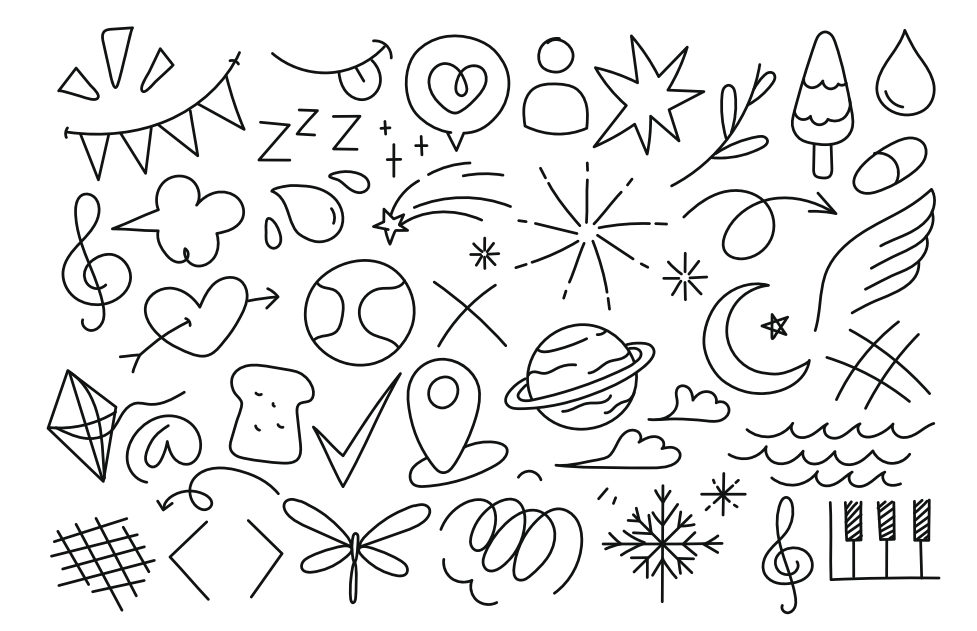

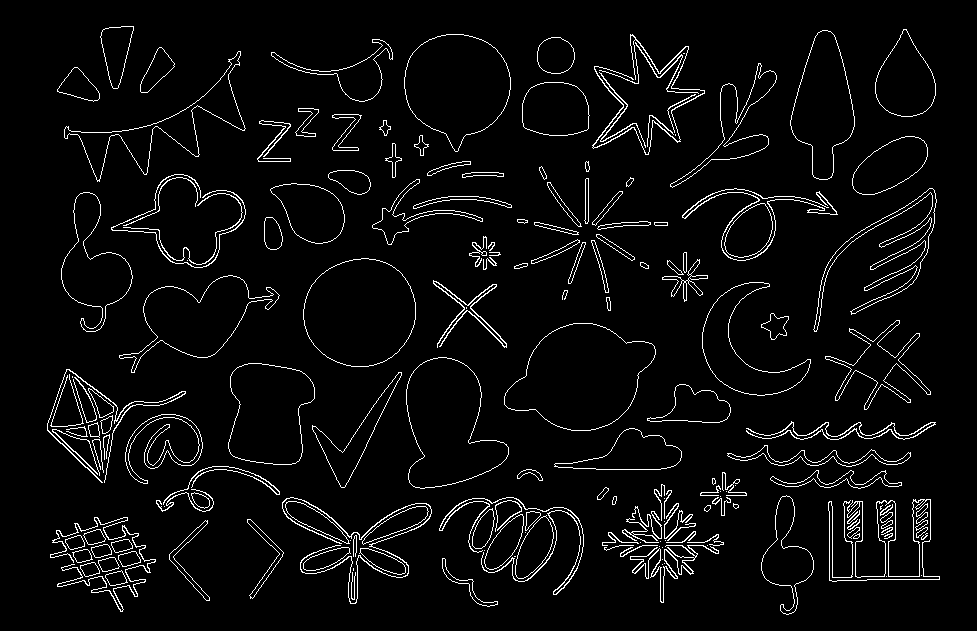

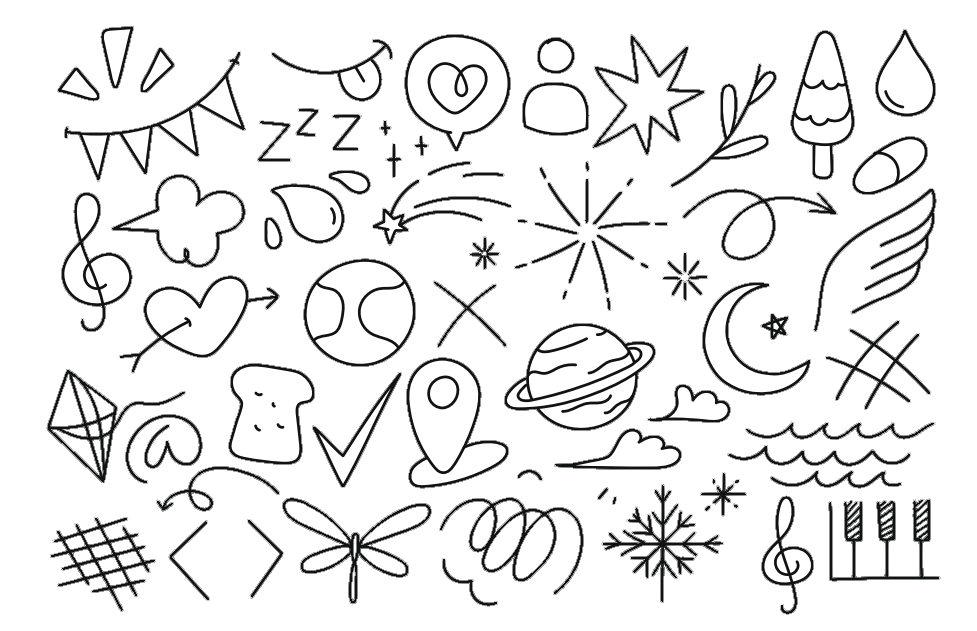

In [ ]:
import cv2
import numpy as np

def complete_incomplete_curves(image_path):
    """
    Complete incomplete curves in an image using inpainting.

    Parameters:
    - image_path (str): Path to the input image file.
    """
    # Read the image from the file
    image = cv2.imread(image_path)  # Load the image from the specified path

    # Convert the image to grayscale for easier processing
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert the image to grayscale

    # Apply Gaussian blur to the grayscale image to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # Blur the image to smooth out noise

    # Perform edge detection to find edges in the image
    edges = cv2.Canny(blurred, 50, 150)  # Detect edges using the Canny algorithm

    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # cv2.findContours finds contours in a binary image
    # - cv2.RETR_EXTERNAL: Retrieve only external contours
    # - cv2.CHAIN_APPROX_SIMPLE: Compresses horizontal, vertical, and diagonal segments

    # Create a mask for inpainting
    mask = np.zeros_like(gray)  # Create an empty mask with the same dimensions as the grayscale image

    # Draw the detected contours on the mask
    for contour in contours:
        cv2.drawContours(mask, [contour], -1, 255, 1)  # Draw each contour on the mask in white

    # Inpainting to complete the curves using the mask
    completed_image = cv2.inpaint(image, mask, inpaintRadius=10, flags=cv2.INPAINT_TELEA)
    # cv2.inpaint performs inpainting to fill in the missing parts using the mask
    # - inpaintRadius: Radius of the circular neighborhood of each point inpainted
    # - cv2.INPAINT_TELEA: Inpainting method using the Telea algorithm

    # Display the results
    cv2_imshow(image)  # Display the original image (use cv2_imshow for Google Colab)
    cv2_imshow(mask)  # Display the mask with contours
    cv2_imshow(completed_image)  # Display the inpainted image with completed curves
    cv2.waitKey(0)  # Wait indefinitely for a key press
    cv2.destroyAllWindows()  # Close all OpenCV windows

# Main function to execute the curve completion
if __name__ == "__main__":
    image_path = "/content/drive/MyDrive/art.png"  # Path to the input image (change as needed)
    complete_incomplete_curves(image_path)  # Call the function to complete curves in the image


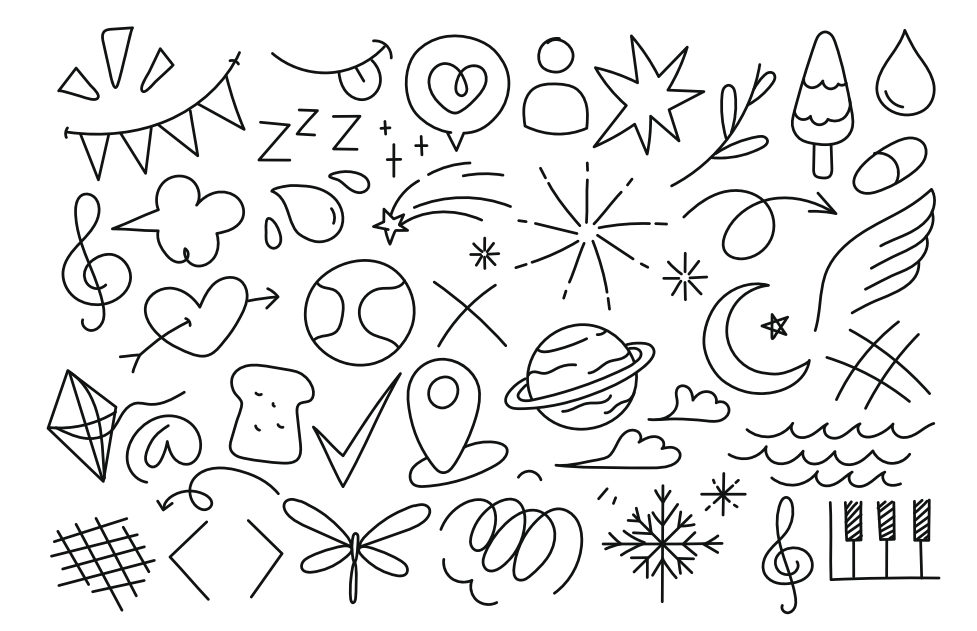

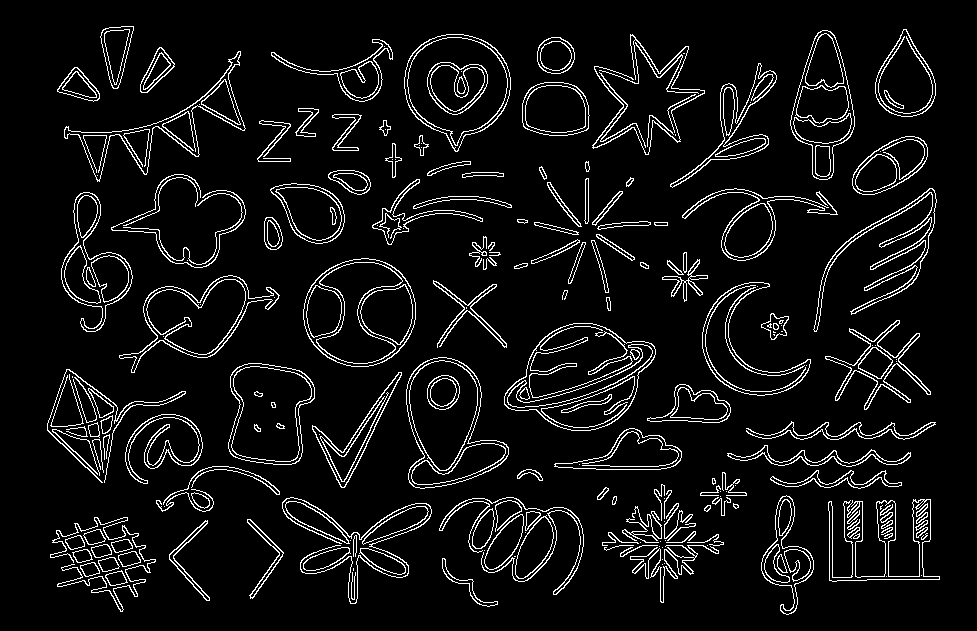

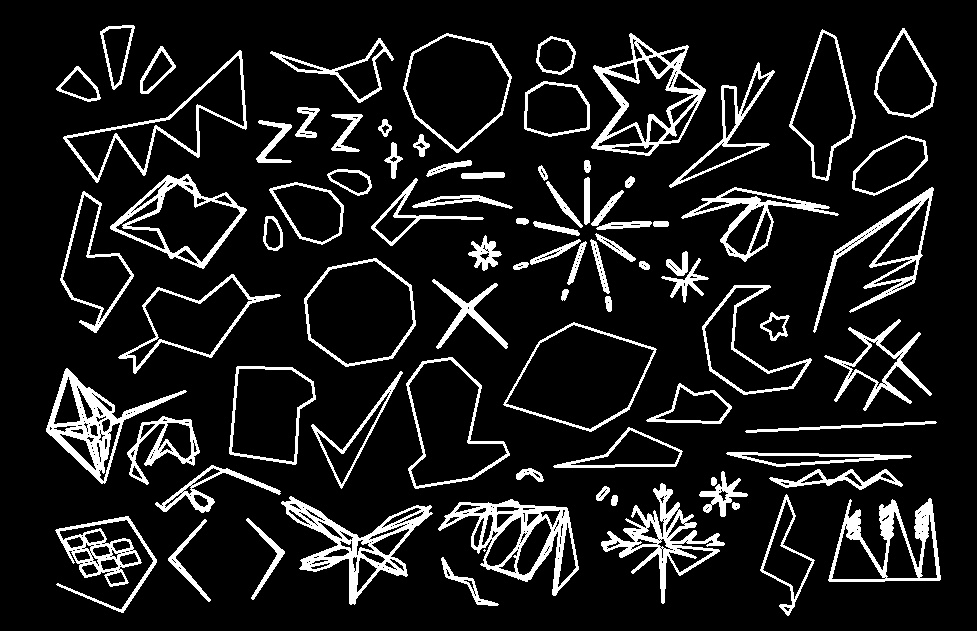

In [ ]:
import cv2
import numpy as np

def regularize_curves(image_path):
    """
    Regularize curves in an image by approximating contours to polygons and smoothing them.

    Parameters:
    - image_path (str): Path to the input image file.
    """
    # Read the image from the file
    image = cv2.imread(image_path)  # Load the image from the specified path

    # Convert the image to grayscale for easier processing
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert the image to grayscale

    # Apply Gaussian blur to the grayscale image to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # Blur the image to smooth out noise

    # Perform edge detection to find edges in the image
    edges = cv2.Canny(blurred, 50, 150)  # Detect edges using the Canny algorithm

    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # cv2.findContours finds contours in a binary image
    # - cv2.RETR_EXTERNAL: Retrieve only external contours
    # - cv2.CHAIN_APPROX_SIMPLE: Compresses horizontal, vertical, and diagonal segments

    # Create an empty image for drawing the regularized curves
    regularized_image = np.zeros_like(image)  # Create a black image with the same size as the input image

    # Process each contour to regularize the curves
    for contour in contours:
        # Approximate the contour to a polygon to reduce the number of points
        epsilon = 0.02 * cv2.arcLength(contour, True)  # Calculate the approximation accuracy
        approx_curve = cv2.approxPolyDP(contour, epsilon, True)  # Approximate the contour to a polygon

        # Create a mask for smoothing the curve
        mask = np.zeros_like(gray)  # Create a black mask with the same size as the grayscale image
        cv2.drawContours(mask, [approx_curve], -1, 255, thickness=cv2.FILLED)  # Draw the approximated curve on the mask

        # Smooth the curve using morphological operations
        kernel = np.ones((5, 5), np.uint8)  # Define a kernel for morphological operations
        smoothed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # Apply closing operation to smooth the mask
        smoothed_curve = cv2.bitwise_and(image, image, mask=smoothed_mask)  # Apply the mask to the original image (not used further in this code)

        # Draw the regularized curve on the output image
        cv2.drawContours(regularized_image, [approx_curve], -1, (255, 255, 255), 2)  # Draw the approximated curve on the regularized image

    # Display the results
    cv2_imshow(image)  # Display the original image (use cv2_imshow for Google Colab)
    cv2_imshow(edges)  # Display the edge-detected image
    cv2_imshow(regularized_image)  # Display the image with regularized curves
    cv2.waitKey(0)  # Wait indefinitely for a key press
    cv2.destroyAllWindows()  # Close all OpenCV windows

# Main function to execute the curve regularization
if __name__ == "__main__":
    image_path = "/content/drive/MyDrive/art.png"  # Path to the input image (change as needed)
    regularize_curves(image_path)  # Call the function to regularize curves in the image


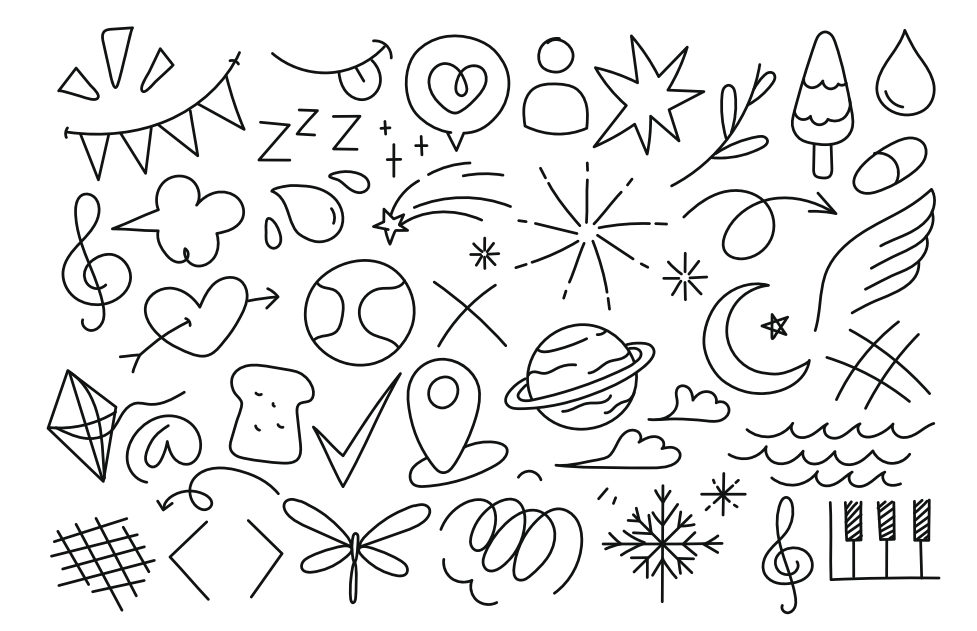

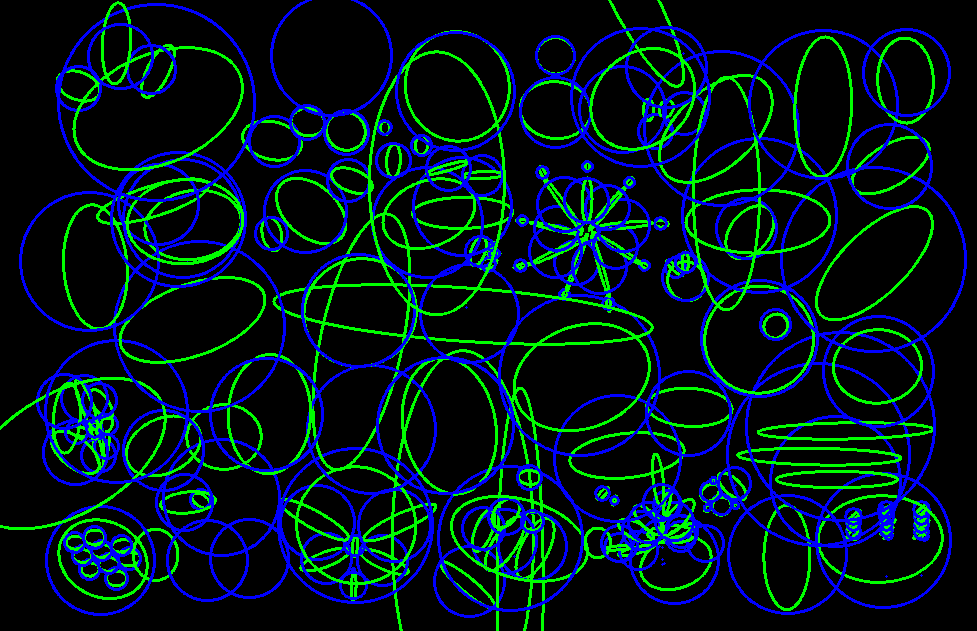

In [ ]:
import cv2
import numpy as np

def fit_regular_shapes(image_path):
    """
    Fit and draw regular shapes (ellipses and circles) on an image based on contours.

    Parameters:
    - image_path (str): Path to the input image file.
    """
    # Read the image from the specified path
    image = cv2.imread(image_path)  # Load the image

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale for easier processing

    # Apply Gaussian blur to the grayscale image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # Reduce noise with Gaussian blur

    # Perform edge detection using the Canny algorithm
    edges = cv2.Canny(blurred, 50, 150)  # Detect edges

    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Retrieve external contours and compress the contour points

    # Create an empty image for drawing regular shapes
    regular_shape_image = np.zeros_like(image)  # Black image with the same size as the input image

    # Process each contour to fit and draw regular shapes
    for contour in contours:
        # Fit an ellipse to the contour if it has enough points
        if len(contour) >= 5:
            ellipse = cv2.fitEllipse(contour)  # Fit an ellipse to the contour
            center, axes, angle = ellipse  # Unpack ellipse parameters
            cv2.ellipse(regular_shape_image, ellipse, (0, 255, 0), 2)  # Draw the ellipse

        # Fit a circle to the contour by finding the minimum enclosing circle
        (x, y), radius = cv2.minEnclosingCircle(contour)  # Find the minimum enclosing circle
        center = (int(x), int(y))  # Convert center coordinates to integer
        radius = int(radius)  # Convert radius to integer
        cv2.circle(regular_shape_image, center, radius, (255, 0, 0), 2)  # Draw the circle

    # Display the results
    cv2_imshow(image)  # Show the original image (use cv2_imshow for Google Colab)
    cv2_imshow(regular_shape_image)  # Show the image with fitted shapes
    cv2.waitKey(0)  # Wait for a key press
    cv2.destroyAllWindows()  # Close all OpenCV windows

# Main function to execute the shape fitting
if __name__ == "__main__":
    image_path = "/content/drive/MyDrive/art.png"  # Path to the input image (adjust as needed)
    fit_regular_shapes(image_path)  # Call the function to fit and draw regular shapes


<ipython-input-6-c087be73ed9b>:48: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x_normalized, points[:, 1], 2)
<ipython-input-6-c087be73ed9b>:48: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x_normalized, points[:, 1], 2)


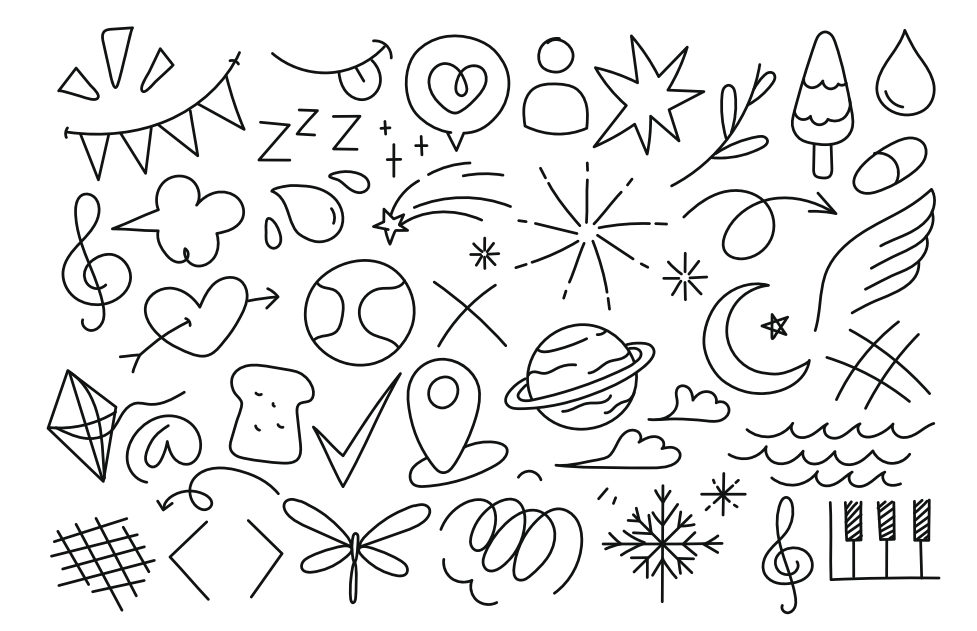

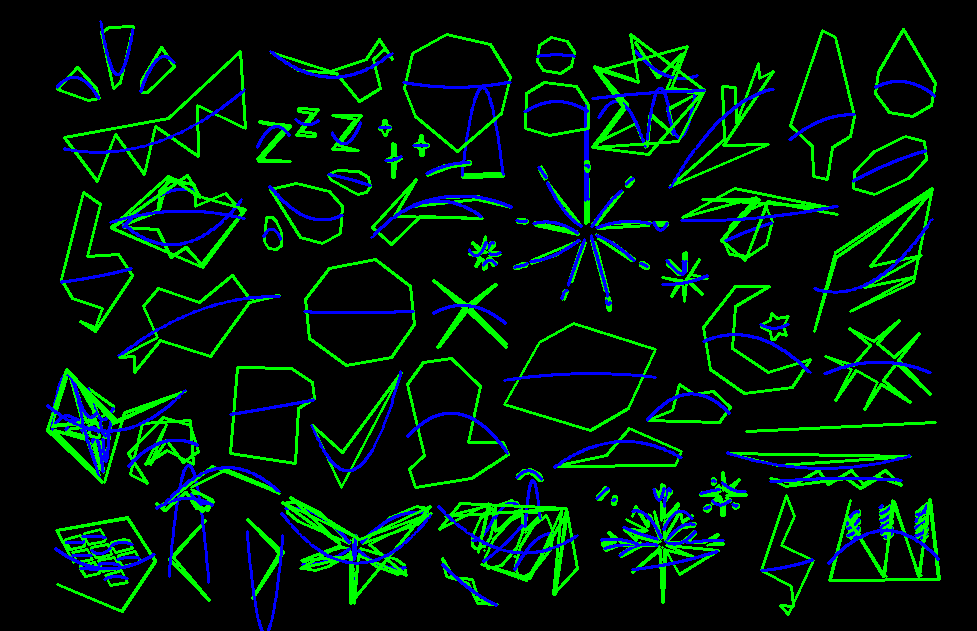

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def regularize_curves(image_path):
    """
    Regularize curves in an image by approximating contours to polygons and optionally smoothing them with polynomial fitting.

    Parameters:
    - image_path (str): Path to the input image file.
    """
    # Read the image from the specified path
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to the grayscale image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Perform edge detection using the Canny algorithm
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty image for drawing the regularized curves
    regularized_image = np.zeros_like(image)

    # Process each contour to regularize the curves
    for contour in contours:
        # Approximate the contour to a polygon to reduce the number of points
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx_curve = cv2.approxPolyDP(contour, epsilon, True)

        # Draw the approximated curve on the regularized image
        cv2.drawContours(regularized_image, [approx_curve], -1, (0, 255, 0), 2)

        # Optionally, smooth the curve using a polynomial fit
        if len(approx_curve) >= 3:  # At least 3 points are needed to fit a polynomial
            points = np.array([pt[0] for pt in approx_curve], dtype=np.float32)

            if points.shape[0] > 2:  # Ensure there are enough points for fitting
                # Normalize the x-values
                x_normalized = (points[:, 0] - np.mean(points[:, 0])) / np.std(points[:, 0])

                # Fit a polynomial of degree 2 (quadratic) to the normalized points
                z = np.polyfit(x_normalized, points[:, 1], 2)
                p = np.poly1d(z)

                # Generate x values within the range and apply the fitted polynomial
                x = np.linspace(x_normalized.min(), x_normalized.max(), num=100)
                y = p(x)

                # Denormalize x-values for plotting
                x_denormalized = (x * np.std(points[:, 0])) + np.mean(points[:, 0])

                smooth_curve = np.vstack((x_denormalized, y)).T.astype(np.int32)

                # Draw the smooth curve on the image
                for i in range(len(smooth_curve) - 1):
                    cv2.line(regularized_image, tuple(smooth_curve[i]), tuple(smooth_curve[i+1]), (255, 0, 0), 2)

    # Display the results using cv2_imshow
    cv2_imshow(image)  # Show the original image
    cv2_imshow(regularized_image)  # Show the image with regularized curves
    cv2.waitKey(0)  # Wait indefinitely for a key press
    cv2.destroyAllWindows()  # Close all OpenCV windows

# Main function to execute the curve regularization
if __name__ == "__main__":
    image_path = "/content/drive/MyDrive/art.png"  # Path to the input image (adjust as needed)
    regularize_curves(image_path)  # Call the function to regularize curves in the image


<ipython-input-34-0c0f4e57ce27>:45: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(points[:, 0], points[:, 1], 2)  # Fit the polynomial
<ipython-input-34-0c0f4e57ce27>:45: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(points[:, 0], points[:, 1], 2)  # Fit the polynomial
<ipython-input-34-0c0f4e57ce27>:45: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(points[:, 0], points[:, 1], 2)  # Fit the polynomial
<ipython-input-34-0c0f4e57ce27>:45: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(points[:, 0], points[:, 1], 2)  # Fit the polynomial
<ipython-input-34-0c0f4e57ce27>:45: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(points[:, 0], points[:, 1], 2)  # Fit the polynomial
<ipython-input-34-0c0f4e57ce27>:45: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(points[:, 0], points[:, 1], 2)  # Fit the polynomial
<ipython-input-34-0c0f4e57ce27>:45: RankWarning: Polyfit may be poorly conditioned

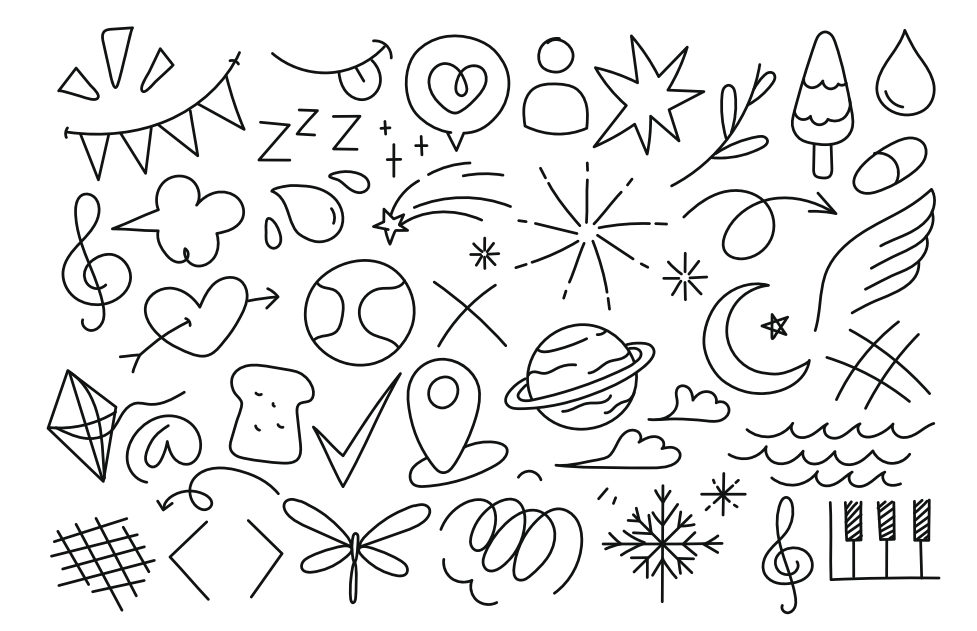

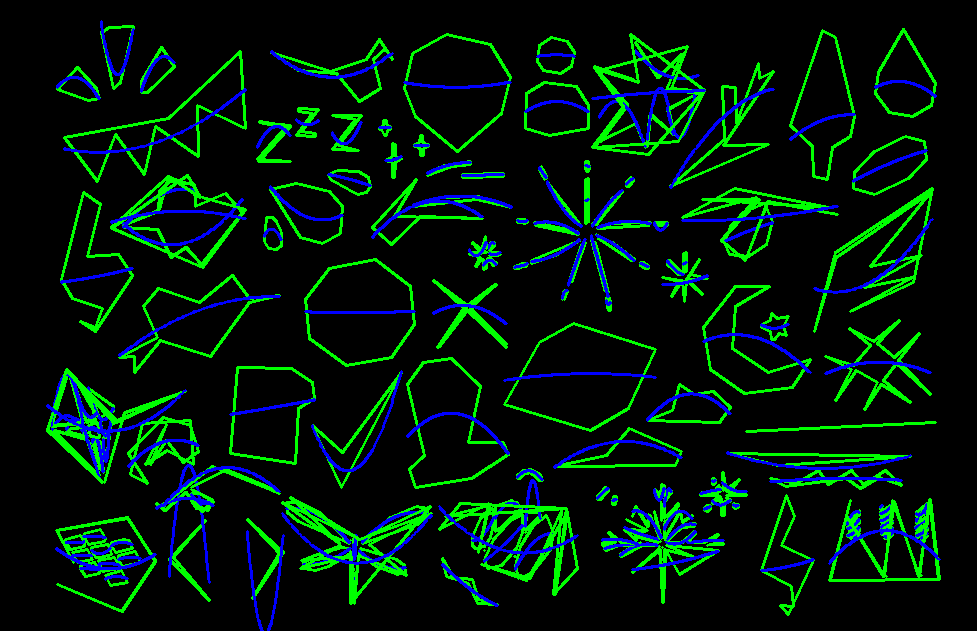

In [ ]:
import cv2
import numpy as np

def regularize_curves(image_path):
    """
    Regularize curves in an image by approximating contours to polygons and optionally smoothing them with polynomial fitting.

    Parameters:
    - image_path (str): Path to the input image file.
    """
    # Read the image from the specified path
    image = cv2.imread(image_path)  # Load the image

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert the image to grayscale

    # Apply Gaussian blur to the grayscale image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # Reduce noise with Gaussian blur

    # Perform edge detection using the Canny algorithm
    edges = cv2.Canny(blurred, 50, 150)  # Detect edges in the blurred image

    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Retrieve external contours and approximate the contour points

    # Create an empty image for drawing the regularized curves
    regularized_image = np.zeros_like(image)  # Black image with the same size as the input image

    # Process each contour to regularize the curves
    for contour in contours:
        # Approximate the contour to a polygon to reduce the number of points
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx_curve = cv2.approxPolyDP(contour, epsilon, True)
        # Approximate the contour with a polygon (curve approximation)

        # Draw the approximated curve on the regularized image
        cv2.drawContours(regularized_image, [approx_curve], -1, (0, 255, 0), 2)  # Draw the polygon

        # Optionally, smooth the curve using a polynomial fit
        if len(approx_curve) >= 3:  # At least 3 points are needed to fit a polynomial
            points = np.array([pt[0] for pt in approx_curve], dtype=np.float32)  # Extract points
            if points.shape[0] > 2:  # Ensure there are enough points for fitting
                # Fit a polynomial of degree 2 (quadratic) to the points
                z = np.polyfit(points[:, 0], points[:, 1], 2)  # Fit the polynomial
                p = np.poly1d(z)  # Create a polynomial function
                x = np.linspace(points[:, 0].min(), points[:, 0].max(), num=100)  # Generate x values
                y = p(x)  # Compute the corresponding y values
                smooth_curve = np.vstack((x, y)).T.astype(np.int32)  # Create smooth curve points
                # Draw the smooth curve on the image
                for i in range(len(smooth_curve) - 1):
                    cv2.line(regularized_image, tuple(smooth_curve[i]), tuple(smooth_curve[i+1]), (255, 0, 0), 2)

    # Display the results
    cv2_imshow(image)  # Show the original image (use cv2_imshow for Google Colab)
    cv2_imshow(regularized_image)  # Show the image with regularized curves
    cv2.waitKey(0)  # Wait indefinitely for a key press
    cv2.destroyAllWindows()  # Close all OpenCV windows

# Main function to execute the curve regularization
if __name__ == "__main__":
    image_path = "/content/drive/MyDrive/art.png"  # Path to the input image (adjust as needed)
    regularize_curves(image_path)  # Call the function to regularize curves in the image


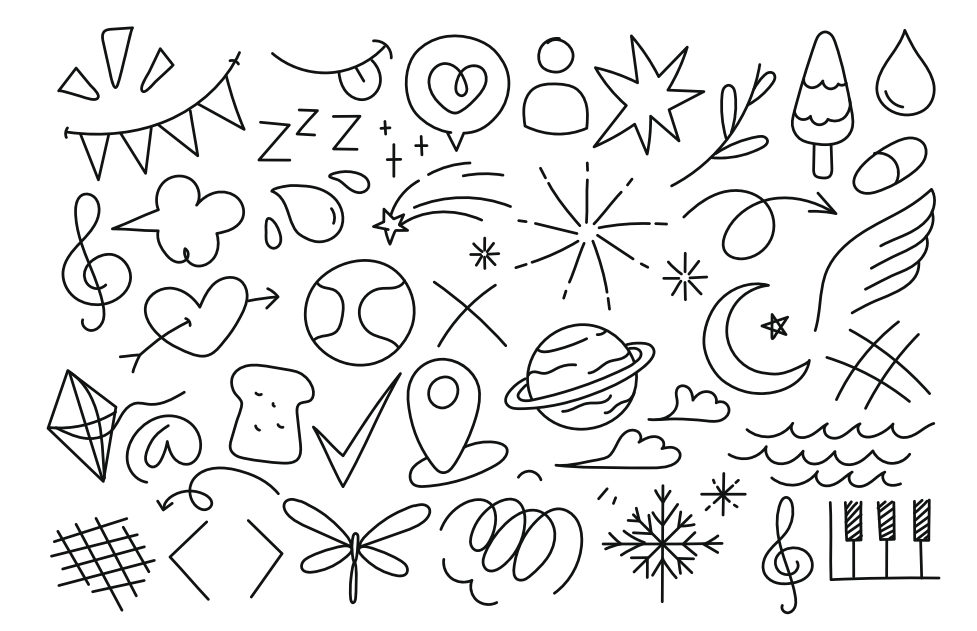

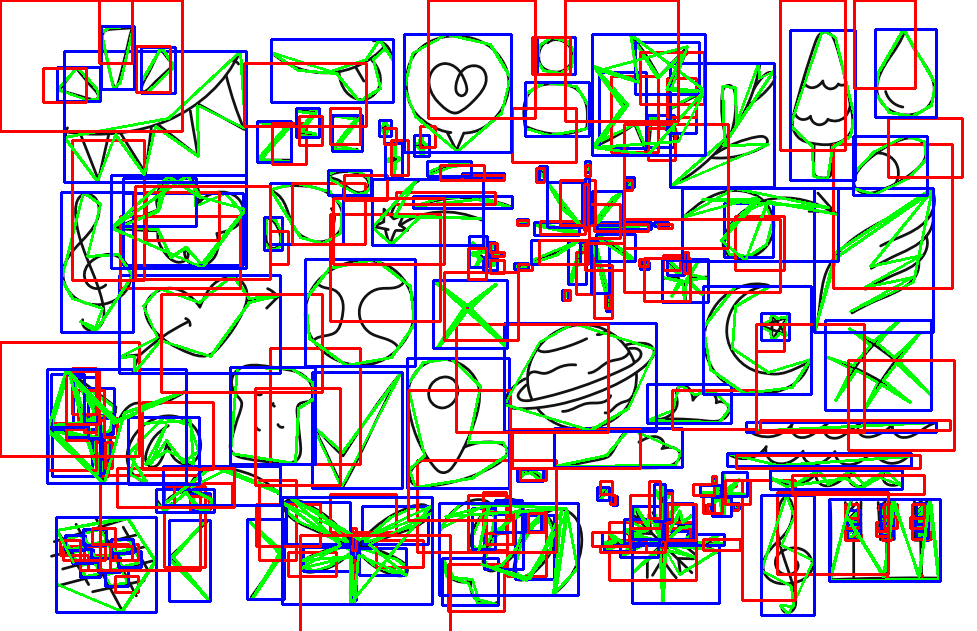

In [ ]:
import cv2
import numpy as np

def align_borders(image_path):
    """
    Align the borders of detected shapes in the image to the nearest axis.

    Parameters:
    - image_path (str): Path to the input image file.
    """
    # Read the image from the specified path
    image = cv2.imread(image_path)  # Load the image

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert the image to grayscale

    # Apply Gaussian blur to the grayscale image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # Reduce noise with Gaussian blur

    # Perform edge detection using the Canny algorithm
    edges = cv2.Canny(blurred, 50, 150)  # Detect edges in the blurred image

    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Retrieve external contours and approximate the contour points

    # Create a copy of the image for drawing aligned shapes
    aligned_image = image.copy()  # Copy of the original image to draw results

    for contour in contours:
        # Approximate the contour to a polygon to reduce the number of points
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        # Approximate the contour with a polygon (curve approximation)

        # Get the bounding box for the contour
        x, y, w, h = cv2.boundingRect(approx)  # Bounding box coordinates and dimensions

        # Draw the original contour on the aligned image
        cv2.drawContours(aligned_image, [approx], -1, (0, 255, 0), 2)  # Draw the polygon in green

        # Draw the bounding box around the contour
        cv2.rectangle(aligned_image, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Draw the bounding box in blue

        # Calculate the center of the bounding box
        center_x = x + w // 2
        center_y = y + h // 2

        # Calculate new aligned coordinates
        new_x = x
        new_y = y

        # Round the center coordinates to align the rectangle
        new_x = center_x - (center_x % w)  # Align x-coordinate to the nearest multiple of width
        new_y = center_y - (center_y % h)  # Align y-coordinate to the nearest multiple of height

        # Draw the aligned rectangle on the aligned image
        aligned_box = (new_x, new_y, w, h)
        cv2.rectangle(aligned_image, (new_x, new_y), (new_x + w, new_y + h), (0, 0, 255), 2)  # Draw aligned box in red

    # Display the results
    cv2_imshow(image)  # Show the original image (use cv2_imshow for Google Colab)
    cv2_imshow(aligned_image)  # Show the image with aligned borders
    cv2.waitKey(0)  # Wait indefinitely for a key press
    cv2.destroyAllWindows()  # Close all OpenCV windows

# Main function to execute the border alignment
if __name__ == "__main__":
    image_path = "/content/drive/MyDrive/art.png"  # Path to the input image (adjust as needed)
    align_borders(image_path)  # Call the function to align borders in the image


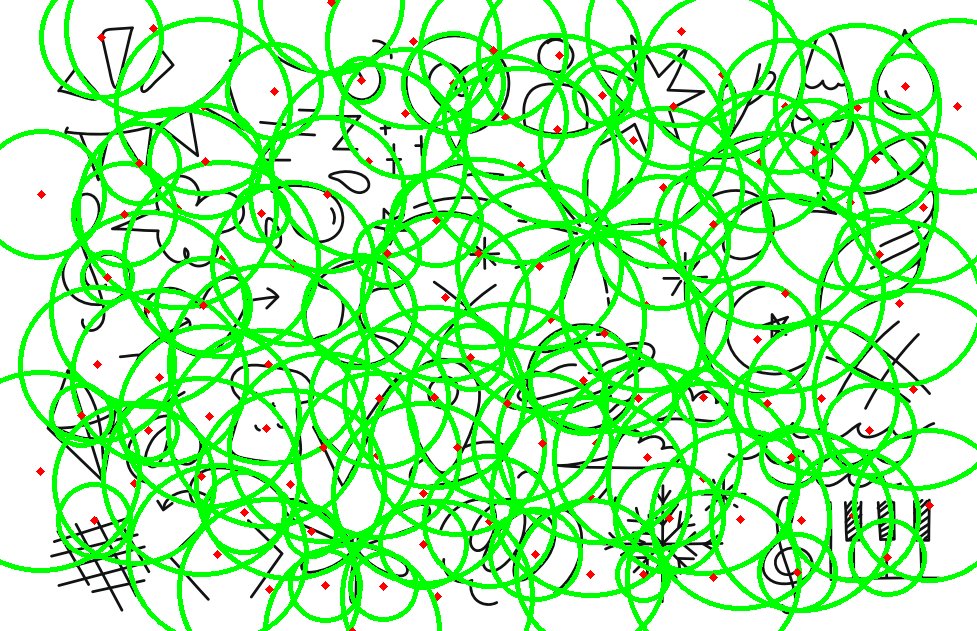

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def fit_circle(image_path):
    """
    Detect and fit circles in the image using Hough Circle Transform.

    Parameters:
    - image_path (str): Path to the input image file.
    """
    # Load the image from the specified path
    image = cv2.imread(image_path)  # Read the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert image to grayscale

    # Apply GaussianBlur to reduce noise and improve circle detection
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)  # Blur the image

    # Detect circles in the image using Hough Circle Transform
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50, param1=50, param2=30, minRadius=20, maxRadius=100)
    # Parameters:
    # - dp: Inverse ratio of the accumulator resolution to the image resolution
    # - minDist: Minimum distance between the centers of the detected circles
    # - param1: Higher threshold for the Canny edge detector
    # - param2: Accumulator threshold for circle centers at the detection stage
    # - minRadius: Minimum circle radius
    # - maxRadius: Maximum circle radius

    # If circles are detected, fit them to perfect circles
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")  # Round and convert coordinates to integers

        for (x, y, r) in circles:
            # Draw the detected circle on the image
            cv2.circle(image, (x, y), r, (0, 255, 0), 4)  # Draw circle in green
            # Optionally, draw the center of the circle
            cv2.circle(image, (x, y), 2, (0, 0, 255), 3)  # Draw center in red

    # Display the output image with fitted circles
    cv2_imshow(image)  # Show the image with circles
    cv2.waitKey(0)  # Wait indefinitely for a key press
    cv2.destroyAllWindows()  # Close all OpenCV windows

# Usage example
fit_circle('/content/drive/MyDrive/art.png')  # Call function with path to your image


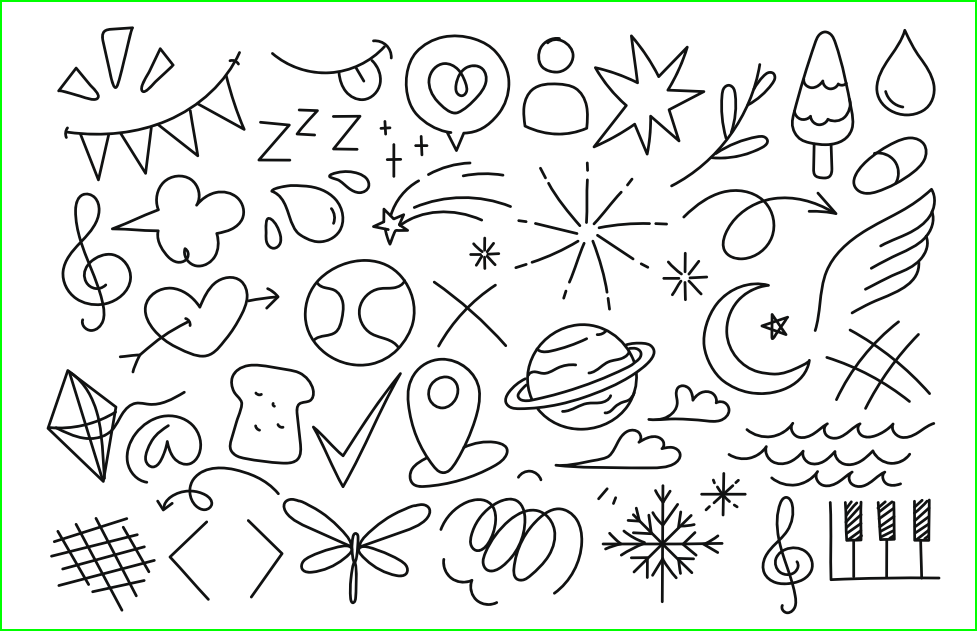

In [ ]:
import cv2
import numpy as np

# Load the image
image = cv2.imread('/content/drive/MyDrive/art.png')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply a threshold to get a binary image
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Find contours in the binary image
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Loop over the contours and approximate them
for contour in contours:
    # Calculate the perimeter of the contour
    epsilon = 0.02 * cv2.arcLength(contour, True)
    # Approximate the contour
    approx = cv2.approxPolyDP(contour, epsilon, True)
    # Draw the approximated contour on the image
    cv2.drawContours(image, [approx], -1, (0, 255, 0), 2)

# Save or display the corrected image
cv2.imwrite('corrected_image.png', image)
cv2_imshow( image)
cv2.waitKey(0)
cv2.destroyAllWindows()




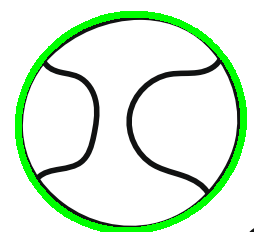

True

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
# Step 1: Load the image
image = cv2.imread('/content/drive/MyDrive/circle.png')
original_image = image.copy()

# Step 2: Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 3: Apply edge detection
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

# Step 4: Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 5: Fit curves and complete the incomplete ones
for contour in contours:
    if len(contour) > 5:
        # Fit an ellipse to the contour
        ellipse = cv2.fitEllipse(contour)
        cv2.ellipse(original_image, ellipse, (0, 255, 0), 5)

# Step 6: Draw the complete curves on the image
cv2_imshow(original_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Save the result
cv2.imwrite('completed_curves.jpg', original_image)


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def complete_curves(image_path, zoom_factor=1.0):
    # Read and preprocess the image
    image = cv2.imread(image_path)
    if zoom_factor != 1.0:
        image = cv2.resize(image, None, fx=zoom_factor, fy=zoom_factor, interpolation=cv2.INTER_LINEAR)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    completed_image = image.copy()

    def find_closest_points(p1, p2, contours):
        min_dist = float('inf')
        closest_pair = (None, None)
        for contour in contours:
            for i in range(len(contour)):
                for j in range(i+1, len(contour)):
                    p3, p4 = contour[i][0], contour[j][0]
                    dist = cv2.pointPolygonTest(contour, (p1 + p2) / 2, True)
                    if dist < min_dist:
                        min_dist = dist
                        closest_pair = (p3, p4)
        return closest_pair

    def interpolate_curve(start_point, end_point, contour, num_points=100):
        curve_points = []
        for i in range(num_points):
            t = i / (num_points - 1)
            x = int(start_point[0] * (1 - t) + end_point[0] * t)
            y = int(start_point[1] * (1 - t) + end_point[1] * t)
            curve_points.append((x, y))
        return curve_points

    for contour in contours:
        # Approximate the contour to a polygon
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
        if len(approx) >= 2:
            for i in range(len(approx)):
                p1 = approx[i][0]
                p2 = approx[(i + 1) % len(approx)][0]
                dist = np.linalg.norm(p1 - p2)
                if dist > 20:  # Threshold distance to consider as a gap
                    closest_points = find_closest_points(p1, p2, contours)
                    if closest_points[0] is not None and closest_points[1] is not None:
                        curve_points = interpolate_curve(closest_points[0], closest_points[1], contour)
                        for i in range(len(curve_points) - 1):
                            cv2.line(completed_image, curve_points[i], curve_points[i+1], (255, 0, 0), 2)

    cv2_imshow(completed_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Main function to run curve completion
if __name__ == "__main__":
    image_path = "/content/drive/MyDrive/art.png"
    complete_curves(image_path, zoom_factor=1.5)
